### EDA

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# df = pd.read_csv('dataset/train.csv.zip')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/quora_data.csv.zip')

In [8]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [9]:
df.shape

(404290, 6)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<Axes: xlabel='is_duplicate'>

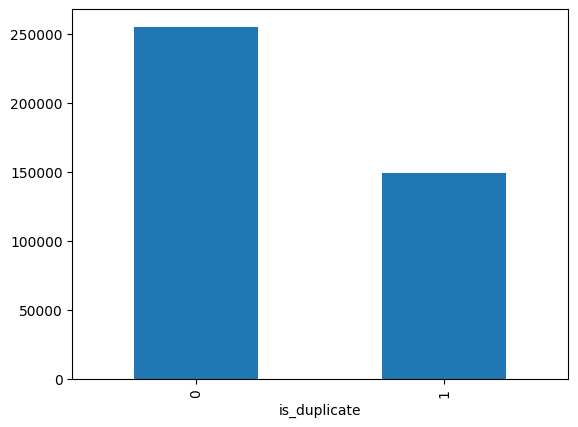

In [11]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [12]:
print(df['question1'].duplicated().value_counts())
print(df['question2'].duplicated().value_counts())

question1
False    290457
True     113833
Name: count, dtype: int64
question2
False    299175
True     105115
Name: count, dtype: int64


In [13]:
# Sampling n rows for training
n = 100000
sample_df_1 = df[df['is_duplicate'] == 1].sample(n=int(n/2), replace=True)
sample_df_0 = df[df['is_duplicate'] == 0].sample(n=int(n/2), replace=True)

df = pd.concat([sample_df_1, sample_df_0])
df = df.sample(frac=1).reset_index(drop=True)

<Axes: xlabel='is_duplicate'>

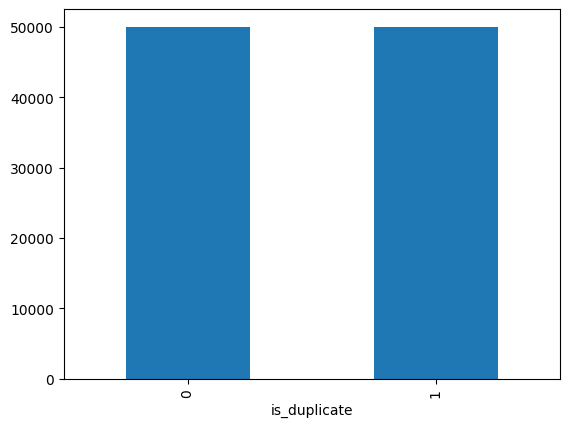

In [14]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,309362,433340,433341,Where does WhatsApp web store images?,Why can't I send images on WhatsApp web?,0
1,304392,58637,75010,Why is my Pug/Cavalier mix puppy afraid of cats?,Why is my Yorkie/Corgi mix afraid of cats?,1
2,204370,307242,307243,What's the best specialization after finishing...,What is the best masters to do after civil eng...,0
3,259331,165505,136735,Who created Quora?,Who has invented Quora?,1
4,1863,3709,3710,What is the best pickup line for engineers?,What is one pickup line that has never failed ...,0


### Text Preprocessing

In [16]:
import string
from nltk.stem import PorterStemmer
import re

def preprocess(text):

    text = str(text)

    #Lowercase
    text = text.lower()

    #Remove html tags
    text = re.sub(r'<.*?>', ' ', text)

    #Remove other Punctuation
    text = re.sub(r'[^\w]', ' ', text)

    #Remove extra space
    text = ' '.join(text.split())

    #Stemming
    stemmer = PorterStemmer()
    text = stemmer.stem(text)


    return text

In [17]:
preprocess('is this not greatest movie ive seen <b> do you like this   ?')

'is this not greatest movie ive seen do you like thi'

In [18]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)

In [19]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,309362,433340,433341,where does whatsapp web store imag,why can t i send images on whatsapp web,0
1,304392,58637,75010,why is my pug cavalier mix puppy afraid of cat,why is my yorkie corgi mix afraid of cat,1
2,204370,307242,307243,what s the best specialization after finishing...,what is the best masters to do after civil engin,0
3,259331,165505,136735,who created quora,who has invented quora,1
4,1863,3709,3710,what is the best pickup line for engin,what is one pickup line that has never failed y,0


### Feature extraction

In [20]:
### Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[['question1', 'question2']], df['is_duplicate'],stratify = df['is_duplicate'], test_size=0.2)

#### Features to add
1. Length of first question
2. Length of second question
3. No of words q1
4. No of words q2
5. Common words ratio (no of common words / total no of words)
6. Is first word same
7. Is last word same
8. No of stopword in q1
9. No of stopword in q2
10. No of negative word in q1
11. No of negative word in q2
13. Fuzzy ratio
14. Fuzzy Partial Ratio
15. Fuzzy sort ratio
16. Fuzzy Set ratio
17. TFIDF for 10000 most repeated words


In [21]:
!pip install fuzzywuzzy

In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
# List of negative words
negative_words = ['not', 'no', 'never', 'none', 'neither', 'nor', 'cannot', 'couldn\'t', 'didn\'t', 'doesn\'t', 'aren\'t', 'isn\'t', 'wasn\'t', 'won\'t', 'wouldn\'t']
nltk_stopwords = set(stopwords.words('english'))

def count_negative_and_stopwords(sentence):
    words = sentence.split()

    # Count the number of negative words in the sentence
    negative_word_count = sum(1 for word in words if word.lower() in negative_words)
    stopwords_count = sum(1 for word in words if word.lower() in nltk_stopwords)

    return negative_word_count, stopwords_count

In [24]:
from fuzzywuzzy import fuzz
from nltk.corpus import stopwords

def get_features(text1, text2):
    # Length of questions
    len1 = len(text1)
    len2 = len(text2)

    #No of words
    word_len1 = len(text1.split())
    word_len2 = len(text2.split())

    # No of common words
    set1 = set(text1.split())
    set2 = set(text2.split())
    common_word_ratio =  len(set1 & set2) / (word_len1 + word_len2)

    #First and last words
    f_word_same = 0
    l_word_same = 0
    if(len(text1.split()) and len(text2.split())):
        f_word_same = int(text1.split()[0] == text2.split()[0])
        l_word_same = int(text1.split()[-1] == text2.split()[-1])

    #No of negative words and stopwords
    negative_len1, stopwords_len1 = count_negative_and_stopwords(text1)
    negative_len2, stopwords_len2 = count_negative_and_stopwords(text2)

    #Fuzzywuzzy
    fuzz_ratio = fuzz.ratio(text1, text2)
    fuzz_partial = fuzz.partial_ratio(text1, text2)
    fuzz_sort = fuzz.token_sort_ratio(text1, text2)
    fuzz_set = fuzz.token_set_ratio(text1, text2)

    return [len1, len2, word_len1, word_len2, common_word_ratio, f_word_same, l_word_same, negative_len1, negative_len2, stopwords_len1, stopwords_len2,
            # name_len1, name_len2, common_name_len, diff_name_len,
            fuzz_ratio, fuzz_partial, fuzz_sort, fuzz_set]

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [25]:
def add_features(df):
    len_features = ['len1', 'len2', 'word_len1', 'word_len_2', 'common_words_ratio', 'f_word_same', 'l_word_same',
                    'negative_len1', 'negative_len2', 'stopwords_len1', 'stopwords_len2', 'fuzz_ratio', 'f_partial', 'f_sort', 'f_set']

    df[len_features] = df.apply(lambda row: get_features(row['question1'], row['question2']), axis=1, result_type='expand')
    return df

In [26]:
X_train = add_features(X_train)

In [27]:
X_train.shape

(80000, 17)

In [28]:
#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
vectorizer.fit(X_train['question1'] + X_train['question2'])

TfidfVectorizer(max_features=5000, stop_words='english')

In [29]:
vectorizer.get_feature_names_out()

array(['000', '10', '100', ..., 'zon', 'zone', 'zuckerberg'], dtype=object)

In [30]:
# vectorize transform
def vectorize_df(df):
    vector_array = vectorizer.transform(df['question1'] + df['question2']).toarray()
    vector_df = pd.DataFrame(vector_array, columns=vectorizer.get_feature_names_out())
    df = pd.concat([df.reset_index(drop=True),vector_df], axis=1)
    df.drop(columns=['question1', 'question2'], inplace=True)
    return df

In [31]:
X_train_vec = vectorize_df(X_train)

In [32]:
X_train_vec.shape

(80000, 5015)

## Building model

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_vec, y_train)

RandomForestClassifier(random_state=42)

In [35]:
from sklearn.metrics import accuracy_score

X_test = add_features(X_test)
X_test_vec = vectorize_df(X_test)
y_pred = model.predict(X_test_vec)
accuracy_score(y_true = y_test, y_pred = y_pred)

0.8286

In [36]:
def is_duplicate(question1, question2):
    d = pd.DataFrame({'question1': [preprocess(question1)], 'question2': [preprocess(question2)]})
    d = add_features(d)
    d = vectorize_df(d)
    return model.predict(d)[0]

In [37]:
ques1 = 'how to learn hindi?'
ques2 = 'how can i learn hindi?'
is_duplicate(ques1, ques2)


1

In [38]:
import pickle

In [40]:
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))